**COMP3670 Assignment 4 - Matrix Decomposition & Dimensionality Reduction**
---

**Enter Your Student ID:** u7235649

**Your Name:** Han Zhang
    

**Submit:** You can write your answers in this file and submit a single Jupyter Notebook file (.ipynb) on Wattle. Rename this file with your student number as 'uXXXXXXX.ipynb'. Otherwise, you can write your programming questions in this file, and submit two files, 'uXXXXXXX.ipynb' for programming and 'uXXXXXXX.pdf' for theory. Please submit them separately instead of a zip file.
    
**Enter Discussion Partner IDs Below:**
- <Enter ID 1>
- <Enter ID 2>
- <Enter ID 3>
    

**Programming Section**
- 1.1 15%
- 1.2 20%
- 1.3 10%
- 1.4 15%
- 1.5 10%
- 2. 30%

---


**PROGRAMMING SECTION**
---

For all of the following, program the solution yourself. Don't just call a library function that does the whole question for you, or you'll get zero (no, that doesn't mean you can't use any library functions, but it does mean that you have to show you understand how to compute the answer yourself).

-----------

   **TASK 0.1:** You know the drill. Import Numpy and PyPlot. We're also going to generate a dataset.


-----------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #This is for 3d scatter plots.
import math
import random
import os
import scipy
from matplotlib.pyplot import imread
from PIL import Image
np.random.seed(13579201)


(133632, 90)


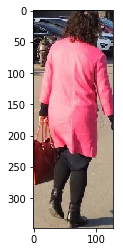

In [2]:
width = 128
height = 348
dimension = (height, width, 3)
images = []
original_images = []
filename = []
for file in os.listdir("./gallery"):
    if file.endswith(".jpg"):
        im = imread("./gallery/" + file)
        original_images.append(im)
        im = im.flatten() # flatten im into a vector
        images.append(im) 
        filename.append(file)
original_images = np.array(original_images)
A_pp = np.stack(images).T # build a matrix where each column is a flattened image
print(A_pp.shape)
plt.imshow(A_pp[:, 0].reshape(dimension))
plt.show()

There are 90 images in the gallery. These images belong to 15 different pedestrians. If two images' file name have same first four digits, then these two images belong to same pedestrian. You can check these images in the `gallery` file folder.

PROGRAMMING EXERCISE 1  
-----------

---

**TASK 1.1:** Let $A\_{pp} \in \mathbb{R}^{D \times N}$ be a matrix of data. Each column of $A\_{pp}$ is a sample of data (1 example for instance). The rows of $A\_{pp}$ are thus the features (dimensions) of each of these samples. Complete the function $preprocess(A\_{pp}) = A, Q\_norms, A\_means$, for which:

$$Q_{i,:} = A\_{pp}_{i,:} - \mu_i$$

...where $\mu_i = \frac{1}{m}\sum_j A\_{pp}_{ij}$ .

$$A_{i,:} = \frac{Q_{i,:}}{||Q_{i,:}||_\infty }$$


$A \in \mathbb{R}^{D \times N}$

$Q_{i,:}$ is the $i^{th}$ row of $Q$.

$A_{i,:}$ is the $i^{th}$ row of $A$.

$||Q_{i,:}||_\infty$ is the infinity norm of $Q_{i,:}$.

$Q\_norms \in \mathbb{R}^{D}$ is a vector recording $||Q_{i,:}||_\infty$ for every feature dimension $i$.

$A\_means \in \mathbb{R}^{D}$ is a vector recording $\mu_i$ for every feature dimension $i$.


**HINT:** 
- If the norm is 0, divide by 1 instead.

---

In [3]:
def preprocess(A_pp):
    # YOUR CODE HERE
    D, N = A_pp.shape      # row, col
    print(D, N)
    
    A = []
    Q_norms = np.zeros(D)
    mu = A_pp.mean(axis=1)
#     mu = np.zeros(D)
    
    for i in range(D):
        Q = A_pp[i] - mu[i]
        Q_norms[i] = np.abs(Q).max()
#         Q_norms[i] = np.linalg.norm(Q, ord=np.inf)       
#         Q_norms[i] = np.linalg.norm(Q)

        A.append(Q / (Q_norms[i] if Q_norms[i] != 0 else 1))
        
    A = np.array(A)
    
    return A, Q_norms, mu

A, Q_norms, A_means = preprocess(A_pp)
print(A)
print(Q_norms)
print(A_means)

133632 90
[[-0.1724009   0.10807779 -0.0433807  ... -0.22288706 -0.2565445
  -0.30703067]
 [-0.18473014  0.10863161 -0.06061556 ... -0.20729643 -0.33141102
  -0.30884473]
 [-0.1783777   0.18074693 -0.01003803 ... -0.17276638 -0.42527589
  -0.31304944]
 ...
 [ 0.2266803  -0.50166113  0.33401482 ...  0.53335037 -0.60899566
  -0.50166113]
 [ 0.19386932 -0.4756655   0.27453617 ...  0.50847002 -0.61279914
  -0.49986556]
 [ 0.01978267 -0.27277793  0.10337141 ...  0.40429089 -0.63220953
  -0.51518529]]
[178.26666667 177.25555556 178.21111111 ... 130.43333333 123.96666667
 119.63333333]
[ 70.73333333  71.74444444  76.78888889 ... 140.43333333 135.96666667
 130.63333333]


---

$A \in \mathbb{R}^{D \times N}$ as above is a matrix of data where every column is a sample of data, and every row is a feature of that data. In this case, we're going to be working with images. Each column $A_{:,j}$ of $A$ is an image of a pedestrian. 

"But an image is a square grid with three color channels" you might be thinking. Well, we've simply taken every column of the image and stacked them vertically, converting a 128 column $ \times $ 348 row pixel image with 3 channels into a vector which length is 133632.

Hence $D = 133632$ and we have $N = 90$ images.

Our objective is to describe each image of a pedestrian as a linear combination of other images. These other images are called Eigen Pedestrians. The Eigen Pedestrians, when flattenned into a column vector, is 133362 dimensional. These vectors are the Eigenvectors of the matrix $AA^T$.

---

**TASK 1.2:** Use $np.linalg.eig()$ and the functions you defined above to complete the function $eigen\_person(A) = F, D$.

$D$ is the matrix of eigen values. 

$F$ is the eigen pedestrians.

Make sure you preprocess the data.

**HINT:** 
- You'll need to ensure the columns of $F$ are unit vectors.
- np.cov()
- np.linalg.eig()
- Matrix size is a big issue when calculating the eigen values. You need to make sure it won't take too much **space or time**.
- If you've computed things correctly, all your eigen values should be real numbers (the imaginary components should be 0). Thus, you can ignore the error about imaginary / complex values.

---

In [4]:
def eigen_ped(A):
    # YOUR CODE HERE

    d, n = A.shape

    S_ = A.T@A
    
    D_, F_ = np.linalg.eig(S_)
    
    D = np.zeros(d)
    D[0:n] = D_

    F = np.zeros_like(A)
    for i in range(n):
        F_i = A @ F_[:, i]
        F[:, i] = F_i / np.linalg.norm(F_i)
    
#     print(F, "\n")
#     print(D)
    return F, D

#For the purposes of doing this assignment, this code isn't really here. Pretend it's engraved in rock.
F, D = eigen_ped(A)
F_real = np.real(F)

# d, n = F_real.shape
# c1 = 0
# c2 = 0
# thr = 0.000001
# for i in range(1, n):
#     if (F_real[:, i-1].T@F_real[:, i] > thr):
#         c1 += 1
#         print('Orthogonality Check (should be close to 0): ', F_real[:, i-1].T@F_real[:, i])

#     if not math.isclose(np.linalg.norm(F_real[:,i]), 1):
#         c2 +=1
#         print(i, F_real[:,i])
#         print('Unit Vector Check: ', math.isclose(np.linalg.norm(F_real[:,i]), 1), np.linalg.norm(F_real[:,0]))
# print(c1, c2)

print('\nOrthogonality Check (should be close to 0): ', F_real[:, 0].T@F_real[:, 1])
print('Unit Vector Check: ', math.isclose(np.linalg.norm(F_real[:,0]), 1))
print(F.shape) # Should be (133632, 90)
print(D.shape) # Should be (133362)


Orthogonality Check (should be close to 0):  2.2717423645360335e-15
Unit Vector Check:  True
(133632, 90)
(133632,)


---

So, now we have representations of the images as a linear combination of the columns of $F$. Using $F$ and $Q\_norms, A\_means$ to reconstruct an image.

---

**TASK 1.3:** Complete the function $reconstruct\_image(Img, F, Q\_norms, A\_means) = R$, where $R \in \mathbb{R}^{348 \times 128 \times 3}$

---

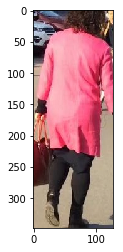

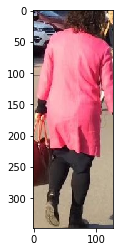

In [5]:
def reconstruct_image(Img, F, Q_norms, A_means):
    # YOUR CODE HERE
    
    D, N = F.shape

    z = F.T @ Img
    x = F @ z
    
    im = x * Q_norms + A_means
    im = im / 255
    im = im.reshape((348, 128, 3))
    im = np.clip(im, 0, 1)
    return im


#Display Code. Shoo! Away with you!
Idx = 1
Img = A[:, Idx]
R = reconstruct_image(Img, F, Q_norms, A_means)
plt.imshow(R)
plt.show()
R = A_pp[:, Idx].reshape(dimension)
plt.imshow(R)
plt.show()
# Two images should look identical

---

Recall the lecture, in which we rotated a vector until we found the largest value for the projection of the data onto that vector.

This was the eigen vector corresponding to the largest eigen value of that dataset. It was the "direction of greatest variance".

An eigen value $d_j$ in the $j^{th}$ column of $D$ (the matrix of eigen values), is associated with an eigen vector (or eigen pedestrian) in the $j^{th}$ column $f_j$ of $F$.

The variance of the data in the direction of $f_j$ is exactly $d_j$. So the $\sum_j d_j$ is the total variance of the dataset in all directions.

When we project the dataset onto an eigen pedestrian $f_k$, we "capture" a percentage of this variance $\frac{d_k}{\sum_j d_j}$. For example, if $\sum_j d_j = 100$, and we project our data on to the 2 eigen pedestrians $f_1$ and $f_2$ with corresponding eigen values $d_1 = 19$ and $d_2 = 3$, then we've captured $\frac{22}{100} = 22\%$ of the variance of the dataset.

---

**TASK 1.4:** Complete the function: 

$$reduce\_dimensionality(image\_vector, k, F, D, A\_means, Q\_norms) = compressed\_image, p$$

This function projects an image vector onto the $k$ eigen pedestrians corresponding to the $k$ largest eigen values, and returns the coefficients of the compressed image $compressed\_image$ and the number $p$, which is percentage of variance captured by the $k$ eigen pedestrians.

**HINT:** 
- Remember to preprocess the image vector.
- In the original version of this question, you were expected to modify the input parameters. This is no longer required as I've included them below as needed. 
- $compressed\_image \in \mathbb{R}^{N}$. In the below example, $k=3$, so $compressed\_image$ should have $3$ non-zero elements, and $N-3$ elements which are 0.
- np.eig() automatically orders eigen values for you.
- As a general tip with arrays, remember, writing array = Img will turn array into Img. Instead, us array = Img.copy().

---


Variance Captured: 78 %
Compressed Image: 


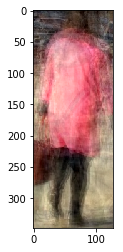

Original Image


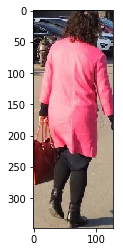

In [6]:
def reduce_dimensionality(image_vector, k, F, D, A_means, Q_norms):
    # YOUR CODE HERE
    d, n = F.shape
    
    valsIndex = np.argsort(-D)
    valsIndex = valsIndex[:k]
        
    eigenvect = np.zeros_like(F)
    eigenvect[:, valsIndex] = F[:, valsIndex]
#     eigenvect[valsIndex] = F[valsIndex]

    img = image_vector - A_means
    img = img / Q_norms
    
    z = eigenvect.T @ img
    compressed_image = eigenvect @ z
    
#     print(D[valsIndex].sum(), "of", D.sum())
    p = D[valsIndex].sum() / D.sum()
    
#     print(p)
        
    return compressed_image, p

#Display Code. Leave it alooooooooooone.
#You can mess with settings, but return them to their original values.
Idx = 0
compressed_image, p = reduce_dimensionality(A_pp[:, Idx], 30, F, D, A_means, Q_norms)
print('Variance Captured:', int(p * 100), '%')

R_c = reconstruct_image(compressed_image, F, Q_norms, A_means)
print('Compressed Image: ')
plt.imshow(R_c)
plt.show()
Img = A[:, Idx]
R_o = A_pp[:, Idx].reshape(dimension)
print('Original Image')
plt.imshow(R_o)
plt.show()

Now, lets using the tool to do a simple classification task.

**TASK 1.5:** Complete the function: 

$$the\_nearest\_image(image\_vector, k, F, D, A\_means, Q\_norms) = index\_of\_the\_nearest\_image$$

Using the function in task 1.4 to project an image vector onto the $k$ eigen pedestrians corresponding to the $k$ largest eigen values. 
Use this projection for a nearest-neighbour search over all the 90 persons. Returns the index of the nearest image.

The index of the first image is zero. 

**HINT:** 
- First you need to calculate all compressed image, then make search
- Using Euclidean distance to calculate the distance between two vectors.

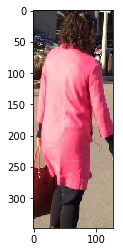

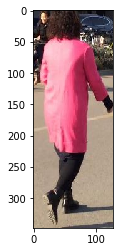

In [7]:
def the_nearest_image(image_vector, A_pp, k, F, D, A_means, Q_norms):
    # YOUR CODE HERE
    d, n = A_pp.shape
    ref_img, p = reduce_dimensionality(image_vector, k, F, D, A_means, Q_norms)
    diff = np.array([np.inf for _ in range(n)])
    for i in range(n):
        img = A_pp[:, i]
        c_img, p_ = reduce_dimensionality(img, k, F, D, A_means, Q_norms)
        diff[i] = np.linalg.norm(c_img - ref_img)
    idx = np.argsort(diff)[0]
#     print(diff)
#     print(np.argsort(diff))
    return idx
    
# im2 = imread("./query/0003_c5_0013.jpg")
# im2 = imread("./query/0006_c14_0021.jpg")
im2 = imread("./query/0001_c5_0022.jpg")

im2 = im2.flatten()
idx = the_nearest_image(im2, A_pp, 30, F, D, A_means, Q_norms)

plt.imshow(im2.reshape(dimension))
plt.show()
plt.imshow(A_pp[:, idx].reshape(dimension))
plt.show()

You may have found out that the method in Task 1.5 is not effective for some queries. A possible reason is that we simply used pixels as the image feature. Now, try to find a better image feature or distance metric, or other improvements to solve the problem.

**TASK 2:** Complete the function
   
$$image\_similarity\_ranking(image\_gallery, query) = list\_of\_index\_of\_the\_images$$

Image_gallery is the collection of all 90 images. The dimension of it is $90 \times 348 \times 128 \times 3$

Query is one image with dimension $348 \times 128 \times 3$.

Unlike Task 1.5, the return value should be a list filled with indices. The index ($0,1,...,89$) should correspond to the sorted gallery images according to their similarities with the query. That is, the first element in the index corresponds to the image with the highest similarity to the query. The second element in the index corresponds to the image with second highest similarity to the query, etc. The length of the result should be 90, same as the number of gallery images. **The indices of the images in the gallery start from zero**. 

We provide you with a gallery with 90 images and 3 query images. You can use these images to improve your algorithm. In our evaluation, we will use new query images (not provided to you) to probe your gallery of 90 images. 


**Requirements:** 
- You are not allowed to import any other packages except Numpy and Scipy. (Your are allowed to import packages in Numpy or Scipy, such as scipy.signal; don't use deep learning). 
- You are not allowed to use external data in any way. 
- You can find inspiration from the internet or research papers (you must cite the source you get your idea from). However, you have to code by yourself. 
- Your implementation (e.g., feature extraction, nearest neighbor search) should be of reasonable speed, e.g., within seconds. You will have 0 if your algorithm takes too much time to run (e.g., more than a few minutes). 
- Your implementation should be runnable on typical desktop computers or laptops (4 or 8 GB memory, for example). If it's only runnable on servers with big memories (in other words, they cannot be executed on tutors' PCs), you will receive 0. 
- Your program should not write any file to the hard disk. 
- You can't use the filename to do the task trivially. In other words, you must use a machine learning solution.
- You are free to improve the feature, the distance metric, both, or other aspects.
- We did not provide training data, so don't do any training using any data. Just use hand-crafted features (e.g., color features, texture features, pixel features) and hand-crafted distance metrics (e.g., Euclidean distance)

Marking criteria overview: Our evaluation will use some new test queries (not provided to students) to probe your gallery data (90 images). We will then calculate a matching score for your returned indices, which is a weighted sum of your top-1, 2, 3, 4, 5 accuracy. Here, top-$k$ accuracy measures the percentage of queries for which you could find the true match within the top-$k$ position of the rank list. Your mark will be given based on your accuracy. For example, if your accuracy is within top $p$% ($p$ to be determined) in the class, you will receive full marks; if your improved method is even lower than the method in Task 1.5, you will receive 0; If your accuracy is in the middle, you will receive partial marks (detailed marks to be determined). If your program contains errors/bugs, you will receive 0 (no partial marks here). This question is worth 30 points in the programming part (thus 15 points overall).

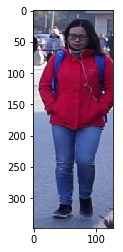

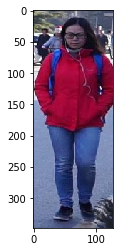

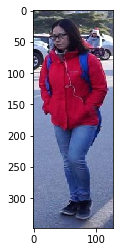

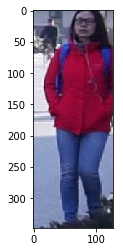

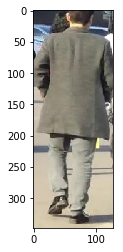

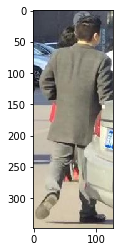

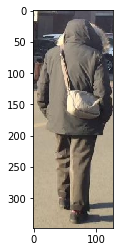

In [8]:
def image_similarity_ranking(image_gallery, image_query):
    index_list = []
    # YOUR CODE HERE

    l = len(image_gallery)
    
    h, w = image_query.shape[:2]
    
    ref = image_query.reshape(h*w, 3)
    ave = ref.mean(axis=1)
    ave_norm = np.linalg.norm(ave)
    
    for i in range(l):
        img_i = image_gallery[i].reshape(h*w, 3)
        ave_i = img_i.mean(axis=1)
        ave_i_norm = np.linalg.norm(ave_i)
        
        sim = (ave/ave_norm) @ (ave_i/ave_i_norm)
        index_list.append(sim)
    
    index_list = np.array(index_list)
    return np.argsort(-index_list)

# path = "./query/0001_c5_0022.jpg"
path = "./query/0006_c14_0021.jpg"
# path = "./query/0003_c5_0013.jpg"
# path = "./query/0035_c1_0008.jpg"
# id_list = image_similarity_ranking(original_images, imread("./query/0001_c5_0022.jpg"))

# plt.imshow(imread("./query/0001_c5_0022.jpg"))

id_list = image_similarity_ranking(original_images, imread(path))

plt.imshow(imread(path))

plt.show()

for i in range(6):
    plt.imshow(original_images[id_list[i]])
    plt.show()

---